# Reinforcement Learning


_I have not failed. I’ve just found 10,000 ways that won’t work_ - Thomas A. Edison

We combine financial modeling with reinforcement learning (RL) to evaluate static and adaptive retirement spending strategies. Traditional approaches, such as the **4% rule**, assume fixed withdrawal rates and asset allocations, that may not adapt well to changing market conditions. Leveraging historical economic data, simulations, and deep learning techniques, we apply RL to learn dynamic strategies which adjust asset allocations based on financial conditions, minimizing the risk of retirees outliving their savings.



In [ ]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from typing import List, Tuple
from finds.database import SQL
from finds.structured import BusDay
from finds.utils import Store, subplots, set_xticks
import torch
from secret import credentials, paths
store = Store(paths['scratch'])
#pd.set_option('display.max_rows', None)
VERBOSE = 0
gym.logger.min_level = gym.logger.ERROR  # Suppress warnings

In [130]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
bd = BusDay(sql, verbose=VERBOSE)
outdir = paths['scratch'] / 'RL'

## Retirement spending policy

A **retirement spending policy** guides how retirees withdraw funds from their savings to sustain their lifestyle while minimizing the risk of depleting assets. The key elements include the **withdrawal strategy**, which defines the initial withdrawal rate (e.g., the 4% rule) and its adjustments over time (e.g., inflation-linked or dynamic withdrawals); **asset allocation**, which balances stocks, bonds, and other investments to optimize growth and risk; **time horizon**, representing the expected duration of withdrawals, typically spanning 20-30 years or more; and **market conditions**, including interest rates, inflation, and asset returns, which influence portfolio sustainability. Effective policies seek to balance spending needs, longevity risk, and market fluctuations to minimize the risk of outliving their assets.

Benz, Ptak and Rekenthaler (2022) found that "For retirees who seek a fixed real withdrawal from their portfolio in retirement, a starting withdrawal rate of 3.8% is safe in Morningstar’s model over a 30-year time horizon, assuming a 90% success rate (defined here as a 90% likelihood of not running out of funds) and a balanced portfolio."




### SBBI data

The **Stocks, Bonds, Bills, and Inflation (SBBI)** dataset provides historical monthly, quarterly, and yearly total returns and yields for major U.S. asset classes, including large-cap stocks, small-cap stocks, corporate bonds, government bonds, and inflation. This data, which dates back to 1926, is commonly used for retirement portfolio simulations.


In [131]:
# Read sbbi data
sbbi_file = paths['data'] / 'SBBI/stocks-bonds-bills-and-inflation-data.xlsx'
df = pd.read_excel(sbbi_file,
                   sheet_name=0,
                   skiprows=list(range(9)) + [10],
                   header=0,
                   usecols='A,B,G,P',
                   index_col=0)
columns_official = df.columns.tolist()
df.columns = ['stocks', 'bonds', 'inflation']
df.index = bd.to_date(df.index)
df

,stocks,bonds,inflation
19260131,0.000000,0.013756,0.000000
19260228,-0.038462,0.006313,0.000000
19260331,-0.057471,0.004129,-0.005587
19260430,0.025305,0.007589,0.005618
19260531,0.017918,0.001412,-0.005587
...,...,...,...
20240831,0.024257,NaN,0.000814
20240930,0.021357,0.100107,0.001604
20241031,-0.009069,-0.046509,0.001151
20241130,0.058701,0.068325,-0.000542


### Scenario generator

To create realistic economic simulations, we extract different 30-year retirement periods from the 100-year span of historical data. These scenarios help model how varying economic conditions impact retirement outcomes.



In [132]:
# Scenario generator: episode, backtest a sample path
class Episodes:
    def __init__(self, data: DataFrame, T: int, num_loops: int = 1):
        self.data = np.log(1 + data)
        self.high = list(self.data.max() + self.data.std()*.1)
        self.low = list(self.data.min() - self.data.std()*.1)
        self.T = T              # number of years per episode
        self.M = (T + 1) * 12   # number of monthly observations per episode
        self.num_loops = num_loops

    def __len__(self):
        return (len(self.data) - self.M + 1) * self.num_loops
        
    def __iter__(self):
        rows = []
        for i in range(self.num_loops):
            rows += np.random.permutation(len(self.data) - self.M + 1).tolist()
        for t in rows:
            df = self.data.iloc[t:(t + self.M), :].reset_index(drop=True)
            yield df.groupby(df.index // 12)\
                    .sum()\
                    .set_index(self.data.index[(t + 11):(t + self.M):12])

Summary statistics of all 30-year episodes:


In [133]:
T = 30
means = {s: [] for s in df.columns}
episodes = Episodes(df, T=T)
for episode in iter(episodes):
    for s in df.columns:
        means[s].append(episode[s].mean())
print('30-year sample periods:')
DataFrame({s: np.mean(x) for s, x in means.items()} | {'N': len(episodes)},
          index=['annualized mean'])

30-year sample periods:


,stocks,bonds,inflation,N
annualized mean,0.105185,0.05502,0.03604,817



We assess the effectiveness of a fixed annual withdrawal strategy by analyzing its performance under different conditions. Key inputs for such strategies include: ortfolio asset allocation (e.g., stock/bond mix); market environment (e.g., past returns and inflation rates); and expected duration of withdrawals.

For example, a typical rule of a fixed 4% withdrawal rate (adjusted for inflation) for a 50% stock / 50% bond portfolio can be evaluated across rolling 30-year periods to estimate the likelihood that a retiree’s savings will last the full duration.

The `Base` model is a simple **buy-and-hold** strategy where funds are invested in a fixed allocation at the start of retirement and are not rebalanced, even if allocation weights drift over time. Withdrawals remain fixed as a percentage of initial wealth, adjusted for inflation.


In [134]:
class BaseModel:
    """Buy-and-hold allocation model where assets weights drift from initial"""
    
    name = 'Buy-and-Hold'
    def __init__(self, T: int, W: List[float]):
        assert W[-1] > 0         # spend must be positive
        self.initial = dict(T=int(T), W=np.array(W))
        
    def reset(self, market_changes: List[float]):
        self.T = int(self.initial["T"])
        self.W = np.array(self.initial["W"])
        return list(market_changes)

    def step(self, action: List, market_changes: List) -> Tuple:
        assert self.T > 0
        self.W[:-1] = np.array(action).flatten() * self.W[:-1].sum() # rebalance
        self.W = self.W * np.exp(np.array(market_changes))           # price changes
        self.T = self.T - 1
        wealth = sum(self.W[:-1])  # remaining wealth
        if wealth < self.W[-1]:
            truncated = True          # is not enough for spend  
            self.W[:-1] = 0.0            
        else:                 
            truncated = False         # is sufficient for spend
            spend = self.W[-1] * self.W[:-1] / wealth  # allocate and deduct spending
            self.W[:-1] = self.W[:-1] - spend
        terminated = not self.T or truncated
        return terminated, truncated

    def predict(self, obs: List) -> List:
        """Allow initial asset allocation to drift"""
        return self.W[:-1] / sum(self.W[:-1])


The `Fixed` model adds annual rebalancing, ensuring that the portfolio maintains a constant stock/bond allocation throughout retirement.

In [135]:
class FixedModel(BaseModel):
    """Allocation model where assets are rebalanced to fixed weights"""
    
    name = 'Annual-Rebalance'
    def predict(self, obs: List) -> List:
        """Action to rebalance asset allocation to fixed initial weight"""
        return self.initial['W'][:-1] / sum(self.initial['W'][:-1])


To assess the risk of retirees running out of money, we simulate rolling 30-year periods and track shortfalls. Our starting scenarios assume a 50/50 stock-bond allocation and a 4% inflation-adjusted withdrawal rule. The probability of shortfall measures the fraction of simulations where assets were depleted before reaching 30 years.

In [136]:
alloc = 50   # 50-50 stocks/bonds initial allocation
rule = 4.0   # 4 percent spending policy
model = BaseModel(T=T, W=[alloc, 100-alloc, rule])

In [137]:
result = {}
for n, episode in enumerate(iter(episodes)):
    obs = model.reset(episode.iloc[0])

    for year in episode.index[1:]:
        obs = episode.loc[year].to_list()
        action = model.predict(obs)
        terminated, truncated = model.step(action, obs)
        if truncated:
            break
    result[episode.index[0]] = model.T
prob = np.mean(np.array(list(result.values())) != 0)
print('Number of 30-year scenerios:', len(episodes))
print('Probability of shortfall:   ', round(prob, 4))

Number of 30-year scenerios: 817
Probability of shortfall:    0.0747


The graph illustrates the years in which retirees ran out of money, with bar heights representing the number of years their assets fell short of the goal. Additionally, plots of compounded asset returns and inflation highlight how periods of lower investment returns and higher inflation increased the risk of shortfall.

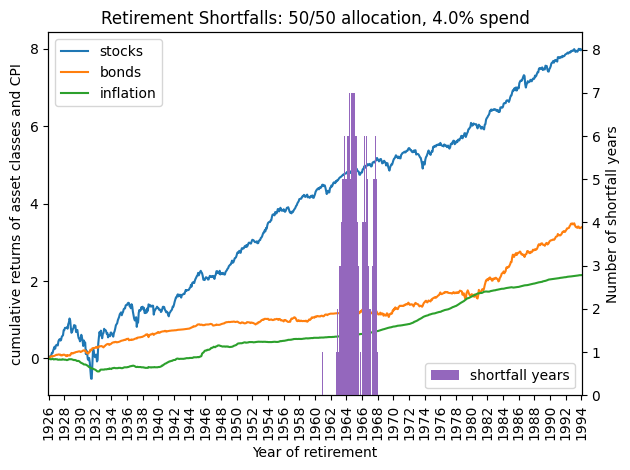

In [138]:
fails = Series(result).sort_index().rename('shortfall_years')
market = df.reindex(fails.index).cumsum()
fails.index = fails.index.astype(str).str.slice(0,4)
market.index = fails.index
ax = market.plot()
ax.set_title(f"Retirement Shortfalls: {alloc}/{100-alloc} allocation, {rule}% spend")
ax.set_ylabel('cumulative returns of asset classes and CPI')
ax.set_xlabel('Year of retirement')
ax.legend(loc='upper left')
##
bx = ax.twinx()
fails.plot(kind='bar', width=1.0, color='C4', ax=bx)
bx.set_ylabel('Number of shortfall years')
bx.legend(['shortfall years'], loc='lower right')
set_xticks(ax=ax, nskip=23, rotation=90)

plt.tight_layout()

### Historical simulations

Next, we expanded the analysis to include a broader range of asset allocations (0% to 100% in stocks) and withdrawal rates (3% to 5%) to evaluate their impact on portfolio longevity.

In [139]:
# range of spending policy rules
rules = np.arange(3, 5.1, 0.1)

# simulate fixed and initial equity allocations from 0 to 100%
allocs = np.arange(0, 105, 5)

In [140]:
TAIL = 0.95
tail = int(100 * (1 - TAIL))
def compute_shortfall(x, q):
    """Compute average number of years of shortfall given tail probability level, q"""
    x = sorted(x)   # each simulation's results (years of shortfall)
    q = int(q * len(x))
    return x[q], np.mean(x[q:])

In [141]:
for num, Model in enumerate([BaseModel, FixedModel]):
    fail = DataFrame(columns=rules, index=allocs, dtype=float)
    shortfall = DataFrame(columns=rules, index=allocs, dtype=float)
    quantile = DataFrame(columns=rules, index=allocs, dtype=float)

    for alloc in tqdm(allocs):
        for rule in rules:

            # Evaluate for this allocation strategy and spending policy
            model = Model(T=T, W=[alloc, 100-alloc, rule])
            result = []
            for n, episode in enumerate(iter(episodes)): # for every 30-year sample
                obs = model.reset(episode.iloc[0])
                for year in episode.index[1:]:
                    obs = episode.loc[year].to_list()
                    action = model.predict(obs)
                    terminated, truncated = model.step(action, obs)
                    if truncated:
                        break
                result.append(model.T)
            fail.loc[alloc, rule] = np.mean(np.array(result) != 0)
            quantile.loc[alloc, rule], shortfall.loc[alloc, rule] = compute_shortfall(result, TAIL)
    store[model.name] = dict(fail=fail, shortfall=shortfall)

100%|██████████| 21/21 [07:32<00:00, 21.57s/it]


We compare the proportion of scenarios where the `Base` buy-and-hold strategy performed better or worse than the `Fixed` strategy with annual rebalancing.

In [142]:
#for model in [BaseModel, FixedModel]:
#    fail = store[model.name]['fail']
#    print(f"Probability of Shortfall: with {model.name} allocation")
#    print(fail.iloc[::-1, :].round(2).to_string())
print('Buy-and-hold outperformed Annual-Rebalance:', 
      round(np.mean(store[FixedModel.name]['fail'] > store[BaseModel.name]['fail']), 3))
print('Annual-Rebalance outperformed Buy-and-Hold:', 
      round(np.mean(store[FixedModel.name]['fail'] < store[BaseModel.name]['fail']), 3))

Buy-and-hold outperformed Annual-Rebalance: 0.374
Annual-Rebalance outperformed Buy-and-Hold: 0.297


### Risk of spending shortfall

To measure the likelihood and severity of depleting funds before the end of retirement, we use two key metrics:

- **Probability of shortfall:** The percentage of simulations where retirees outlived their assets.

- **Expected shortfall period:** This metric quantifies the severity of shortfalls by estimating how many years retirees would be without funds in the worst-case scenarios (e.g., the worst 5% of simulations).

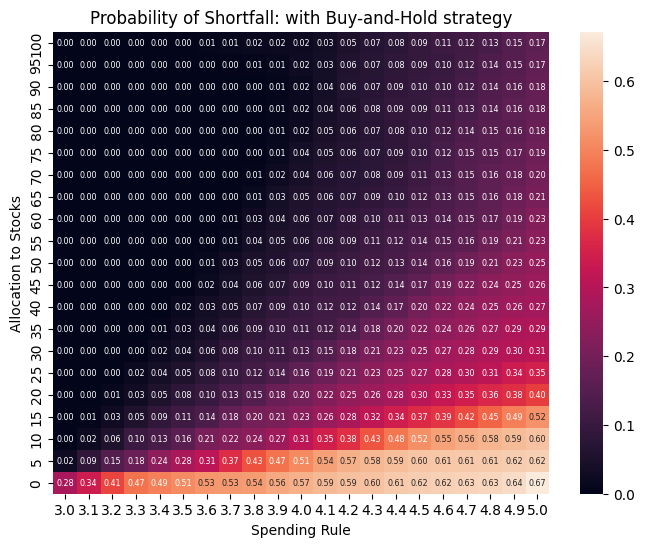

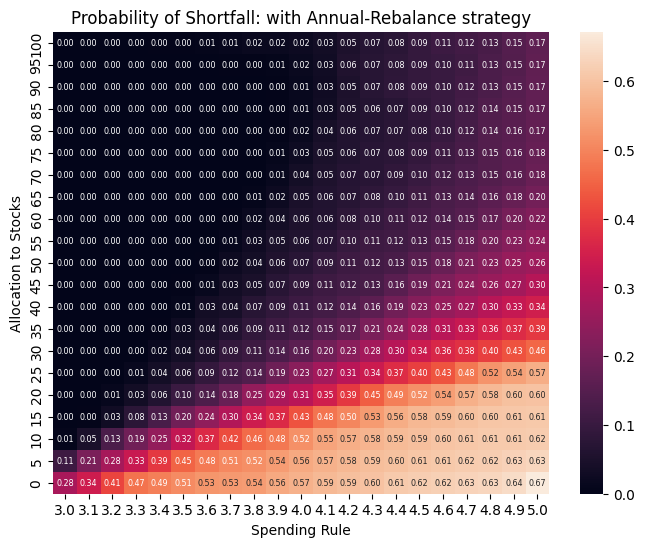

In [149]:
for model in [BaseModel, FixedModel]:
    fail = store[model.name]['fail'].iloc[::-1, :]
    plt.figure(figsize=(8, 6))
    sns.heatmap(fail, annot=True, cbar=True, fmt='.2f', annot_kws=dict(fontsize='xx-small'),
                xticklabels=np.round(fail.columns, 1), yticklabels=fail.index)

    # Labels and title
    plt.xlabel("Spending Rule")
    plt.ylabel("Allocation to Stocks")
    plt.title(f"Probability of Shortfall: with {model.name} strategy")
    plt.show()

**Probability of shortfall:**

Contour lines in the probability of shortfall graph show the combinations of asset allocation and withdrawal rates that result in the same likelihood of running out of money.

In [145]:
def plot_contour(Z, levels, title, label):
    """Helper to plot contour lines at given levels"""
    X, Y = np.meshgrid(rules, allocs)
    fig, ax = plt.subplots(figsize=(10, 6))
    cp = ax.contour(X, Y, Z, levels=levels, cmap='cool')
    ax.set_title(f"{title} with {model.name} strategy")
    ax.set_xticks(rules)
    ax.set_xlabel('spending policy (%)')
    ax.set_yticks(allocs)
    ax.set_ylabel(f'{model.name} equity allocation (%)')
    ax.grid(which='both')
    fig.colorbar(cp, label=label)
    plt.tight_layout()

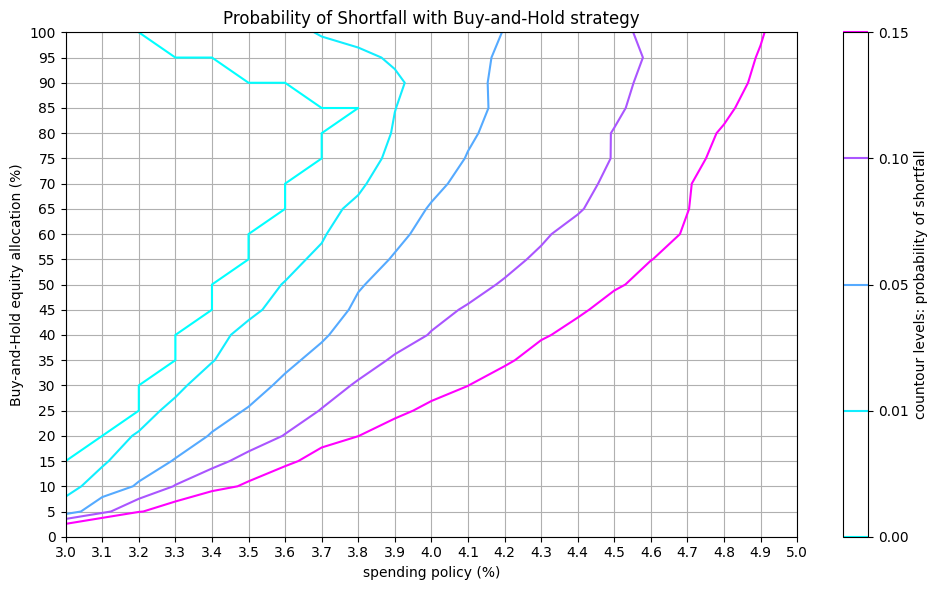

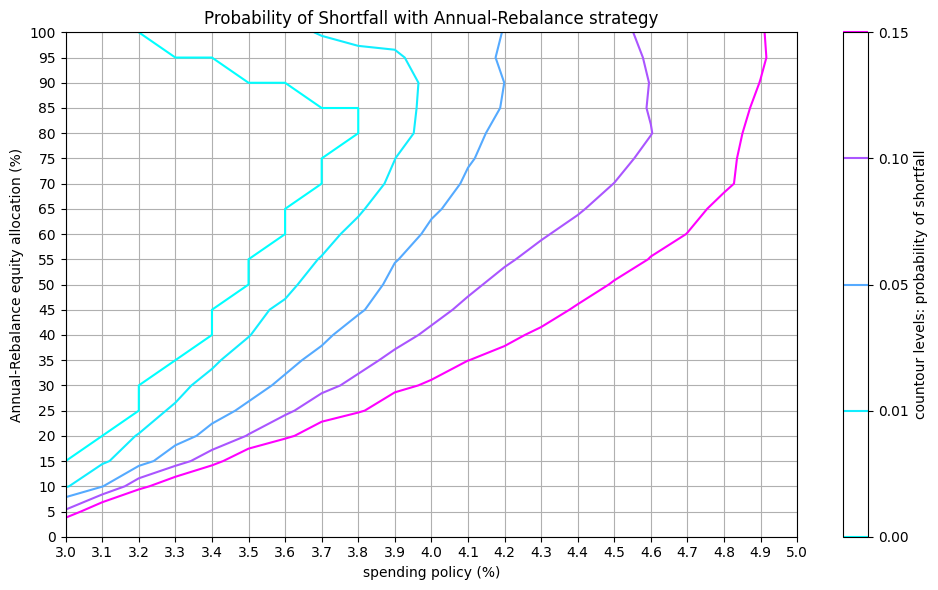

In [146]:
for model in [BaseModel, FixedModel]:    
    fail = store[model.name]['fail']
    plot_contour(fail, levels=[0.0, .01,.05,.1,.15],
                 title="Probability of Shortfall", 
                 label="countour levels: probability of shortfall")

**Expected shortfall period:**

This metric estimates the potential duration of financial shortfalls, which helps retirees plan for worst-case scenarios.

In [147]:
#for model in [BaseModel, FixedModel]:    
#    shortfall = store[model.name]['shortfall']
#    print(f"Expected Years of Shortfall in {tail}% tail: (model.name) allocation")
#    print(shortfall.iloc[::-1, :].round(1).to_string())
print('Buy-and-hold outperformed Annual-Rebalance:', 
      round(np.mean(store[FixedModel.name]['shortfall'] > store[BaseModel.name]['shortfall']), 3))
print('Annual-Rebalance outperformed Buy-and-Hold:', 
      round(np.mean(store[FixedModel.name]['shortfall'] < store[BaseModel.name]['shortfall']), 3))

Buy-and-hold outperformed Annual-Rebalance: 0.059
Annual-Rebalance outperformed Buy-and-Hold: 0.61


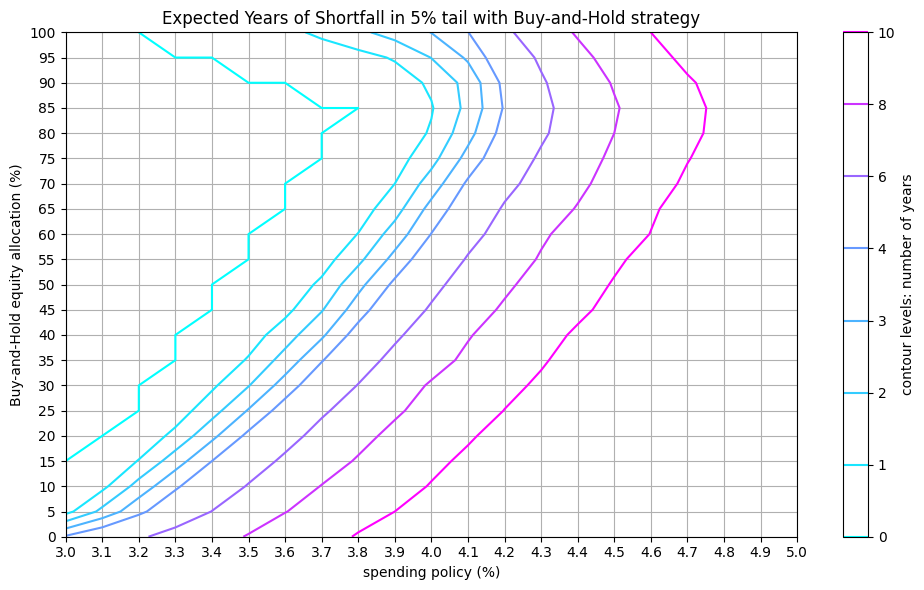

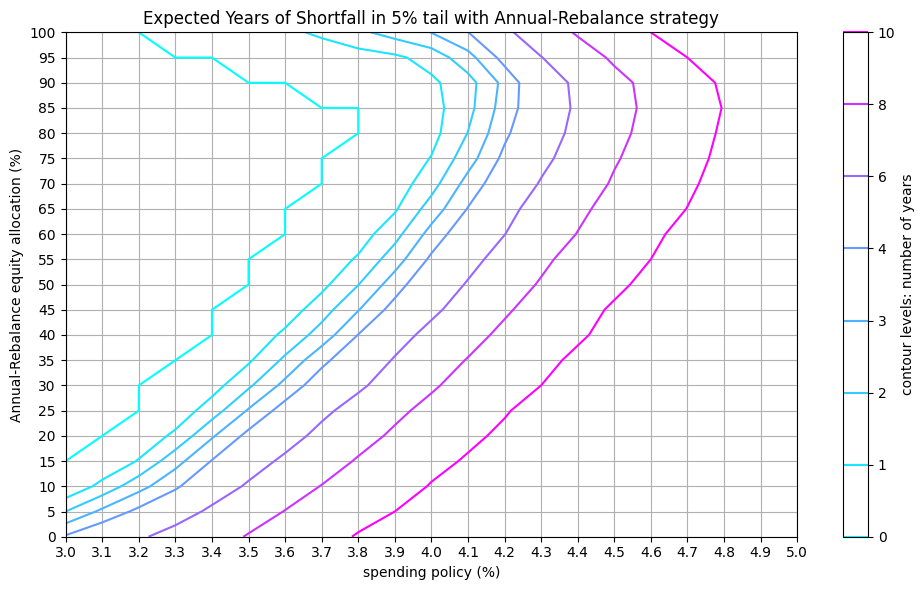

In [148]:
for model in [BaseModel, FixedModel]:    
    shortfall = store[model.name]['shortfall']
    plot_contour(shortfall, levels=[0, 1, 2, 3, 4, 6, 8, 10], 
                 title=f"Expected Years of Shortfall in {tail}% tail",
                 label="contour levels: number of years")

## Deep reinforcement learning

Unlike static asset allocation models, **reinforcement learning (RL)** can learn optimal strategies that adapt to market conditions and remaining wealth.


### Gymnasium environment

The `Gymnasium` (formerly OpenAI Gym) library provides a Pythonic interface for reinforcement learning problems. `Stable Baselines3` (SB3) implements a set of RL algorithms in PyTorchf OpenAI’s Gym library.


https://gymnasium.farama.org/index.html

https://github.com/DLR-RM/stable-baselines3





### State space

During training, the RL model learns to predict optimal spending actions based on the current financial state. The **state space** includes:
- current wealth and allocation,
- recent market (equity and bonds) and inflation changes
- spending amount
- years since retirement

### Actions

**Exploitation**: Selects the action with the highest expected value, based on past training data (e.g., Q-learning, SARSA).

**Exploration**: Tries alternative strategies to discover better long-term policies.

### Reward function

- If assets are depleted, the model applies a severe penalty of $-100$ times the square of remaining years: $-(100 T^2)$
- If wealth is positive, the reward is proportional to the wealth-to-spending coverage ratio: $\sqrt{\frac{W}{S(T+1)}}$



In [12]:
FAIL = 100    # failure reward factor
class CustomEnv(gym.Env):
    """Custom gymnasium environment, using Episodes scenario generator"""
    def __init__(self, model: BaseModel, episodes: Episodes):
        super().__init__()
        self.model = model            # for stepping through a 30-year episode
        self.episodes = episodes      # for generating a sample 30-year episode
        self.iterator = iter(self.episodes)  # iterator to reset a 30-year sample
        T = self.model.initial['T']
        W = self.model.initial['W']
        low = np.array([0] + episodes.low + [0]*len(W))
        high = np.array([T] + episodes.high + [T]*len(W))
        self.observation_space = spaces.Box(low=low, high=high)
        self.action_space = spaces.Discrete(21)
        #self.action_space = spaces.Box(low=0.0, high=1.0)
        
    def reset(self, seed=0):
        super().reset(seed=seed)

        # generate a fresh 30-year episode
        self.episode = next(self.iterator, None)
        if self.episode is None:
            self.iterator = iter(self.episodes)
            self.episode = next(self.iterator)
        self.n = 0

        # return initial observations
        deltas = self.model.reset(self.episode.iloc[self.n])
        obs = [self.model.T] + list(deltas) + self.model.W.tolist()
        return obs, {}


    def step(self, action):
        S = self.model.W[-1]            # amount to spend at t-1
        W = np.sum(self.model.W[:-1])   # wealth at t-1
        T = self.model.T                # year remaining till termination

        # Convert action to asset allocation weights
        action = action * 0.05
        action = np.array([action, 1-action])
        
        # Grab next market move at time t
        self.n = self.n + 1
        deltas = self.episode.iloc[self.n].tolist()

        # Apply rebalance wealth and market move (t=1)
        terminated, truncated = self.model.step(action, deltas)

        # Calculate reward (t=1)
        reward = -(T*T*FAIL) if truncated else math.sqrt(W / (S*T))

        # Return as next observation
        obs = [T] + list(deltas) + self.model.W.tolist()
        return obs, reward, terminated, truncated, {}

Helpers to evaluate trained model

In [14]:

def evaluate(env, model, episodes):
    """Return success likelihood, shortfalls and asset allocation actions"""
    result = []
    actions = {t: [] for t in range(episodes.T + 1)}  # to store predicted actions
    for n, episode in enumerate(iter(episodes)):
        obs, info = env.reset()
        terminated = False
        while not terminated:
            action, _states = model.predict(np.array(obs))
            actions[env.model.T].append(float(action))
            obs, rewards, terminated, truncated, info = env.step(action)
        result.append(env.model.T if truncated else 0)
    #print(n, truncated, action, rewards, env.model.W)
    return np.mean(np.array(result) != 0), *compute_shortfall(result, TAIL), actions

### Deep Q-Network (DQN) 

We use **Deep Q-Networks (DQN)** from `Stable Baselines3`, which is designed for discrete action spaces. This approach employs **deep reinforcement learning** to maximize wealth longevity while adapting asset allocation strategies dynamically.


In [16]:
TIMESTEPS = int(5e5)
initial_alloc = 50
fail, actions, shortfall, quantile = {}, {}, {}, {}
for rule in tqdm(rules):  # train a model for each spending rule

    # define and train model for this spending rule
    name = str(round(rule, 1))
    W = [initial_alloc, 100-initial_alloc, rule]
    env = CustomEnv(model=BaseModel(T=T, W=W), episodes=episodes)
    clf = DQN('MlpPolicy', env, verbose=VERBOSE)
    clf.learn(total_timesteps=TIMESTEPS)
    clf.save(f"{outdir}/{name}")

    # evaluate model
    test_clf = clf.load(f"{outdir}/{name}", env=None)
    fail[name], quantile[name], shortfall[name], actions[name] =\
        evaluate(env, test_clf, episodes)

    store['dqn'] = dict(fail=fail, shortfall=shortfall,
                        quantile=quantile, actions=actions)

100%|██████████| 21/21 [2:00:19<00:00, 343.79s/it]


In [17]:
print(DataFrame(fail, index=["Deep RL"]).round(2).to_string())

         3.0  3.1  3.2  3.3   3.4  3.5  3.6   3.7   3.8   3.9   4.0   4.1   4.2   4.3  4.4   4.5   4.6   4.7   4.8   4.9   5.0
Deep RL  0.0  0.0  0.0  0.0  0.01  0.0  0.0  0.01  0.02  0.02  0.03  0.06  0.06  0.08  0.1  0.11  0.14  0.12  0.16  0.21  0.19


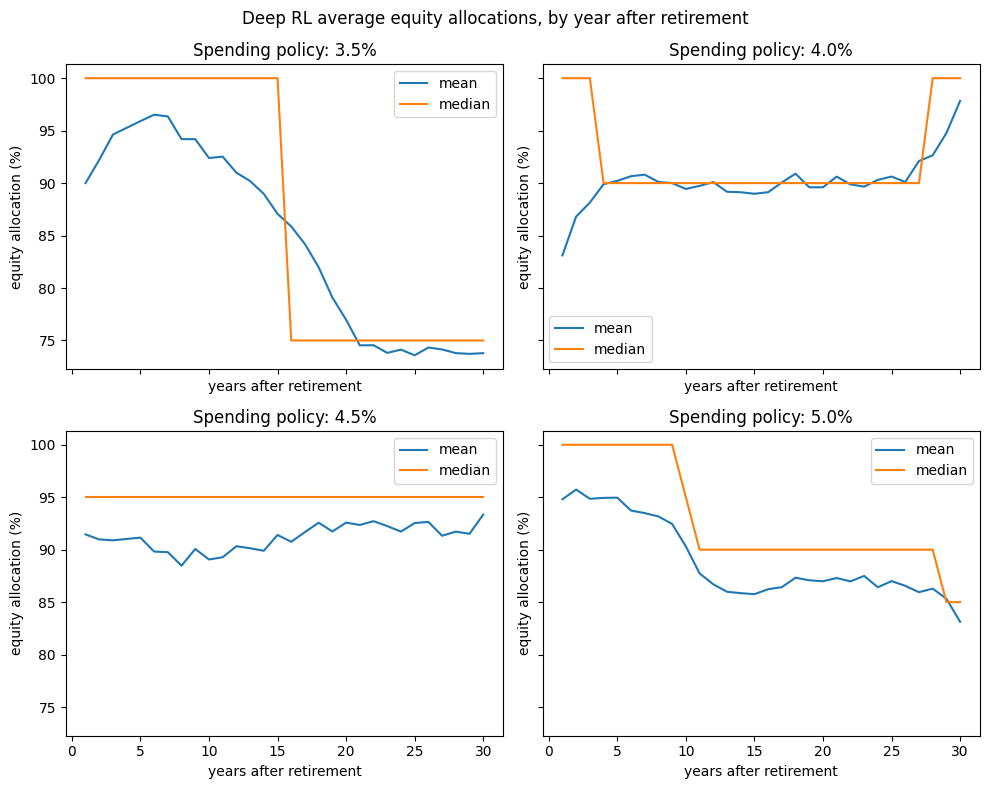

In [18]:
# Plot average allocations over time
labels = list(np.arange(T) + 1)
fig, axs = subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)
plt.suptitle('Deep RL average equity allocations, by year after retirement')
for ax, rule in zip(axs, ["3.5", "4.0", "4.5", "5.0"]):
    y = [[a*5 for a in actions[rule][i]] for i in labels]
    mean = [np.mean(a) for a in y]
    median = [np.median(a) for a in y]
    ax.plot(labels, mean, label='mean')
    ax.plot(labels, median, label='median')
    ax.set_title(f"Spending policy: {rule}%")
    ax.set_xlabel('years after retirement')
    ax.set_ylabel('equity allocation (%)')
    ax.legend()
plt.tight_layout()

**References:**

Richard S. Sutton and Andrew G. Barto, 2018, "Reinforcement Learning: An Introduction", MIT Press.

Christine Benz, Jeffrey Ptak John Rekenthaler, Dec. 12, 2022, "The State of Retirement Income: 2022. A look at how higher bond yields, lower equity valuations, and inflation affect starting safe withdrawal rates", Morningstar Portfolio and Planning Research.

